In [1]:
# https://physionet.org/content/chbmit/1.0.0/chb08/

In [2]:
# Исходные данные
seizure_files = {
    'plus/chb08_02.edf': (2670, 2841),
    'plus/chb08_05.edf': (2856, 3046),
    'plus/chb08_11.edf': (2988, 3122),
    'plus/chb08_13.edf': (2417, 2577),
    'plus/chb08_21.edf': (2083, 2347),

    'plus/chb01_03.edf': (2996, 3036),
    # 'plus/chb01_04.edf': (1467, 1494), 27s
    'plus/chb01_15.edf': (1732, 1772),
    'plus/chb01_16.edf': (1015, 1066),
    'plus/chb01_18.edf': (1720, 1810),

    'plus/chb02_16.edf': (2972, 3053),
    # 'plus/chb02_19.edf': (3369, 3378), 9s


    'plus/chb03_01.edf': (362, 414),
    'plus/chb03_02.edf': (731, 796),
    'plus/chb03_03.edf': (432, 501),
    'plus/chb03_04.edf': (2162, 2214),
    
    'plus/chb03_34.edf': (1982, 2029),
    'plus/chb03_35.edf': (2592, 2656),
    'plus/chb03_36.edf': (1725, 1778),

    'plus/chb05_06.edf': (417, 532),
    'plus/chb05_16.edf': (2317, 2413),
    'plus/chb05_17.edf': (2451, 2571),    
    'plus/chb05_22.edf': (2348, 2465),

    # 'plus/chb05_17.edf': (2451, 2571),
    # 'plus/chb05_17.edf': (2451, 2571),
    
}




clear_files = {
    'minus/chb08_03.edf': False,
    'minus/chb08_04.edf': False,
    'minus/chb08_10.edf': False,
    'minus/chb08_16.edf': False,
    'minus/chb08_17.edf': False,

    'minus/chb02_01.edf': False,
    'minus/chb02_02.edf': False,
    'minus/chb02_03.edf': False,
    
    'minus/chb03_07.edf': False,
    'minus/chb03_09.edf': False,
    'minus/chb03_30.edf': False,

    'minus/chb04_05.edf': False,

    
    # 'minus/chb04_01.edf': False,
    # 'minus/chb04_02.edf': False,
    # 'minus/chb04_02.edf': False,
    
    # 'minus/chb05_03.edf': False,
    # 'minus/chb05_07.edf': False,
    
    # 'minus/chb06_09.edf': False,
    # 'minus/chb06_09.edf': False,

    # 'minus/chb07_09.edf': False,
    # 'minus/chb07_09.edf': False,

}


In [3]:
{k: v[1] - v[0] for k,v in seizure_files.items()}

{'plus/chb08_02.edf': 171,
 'plus/chb08_05.edf': 190,
 'plus/chb08_11.edf': 134,
 'plus/chb08_13.edf': 160,
 'plus/chb08_21.edf': 264,
 'plus/chb01_03.edf': 40,
 'plus/chb01_15.edf': 40,
 'plus/chb01_16.edf': 51,
 'plus/chb01_18.edf': 90,
 'plus/chb02_16.edf': 81,
 'plus/chb03_01.edf': 52,
 'plus/chb03_02.edf': 65,
 'plus/chb03_03.edf': 69,
 'plus/chb03_04.edf': 52,
 'plus/chb03_34.edf': 47,
 'plus/chb03_35.edf': 64,
 'plus/chb03_36.edf': 53,
 'plus/chb05_06.edf': 115,
 'plus/chb05_16.edf': 96,
 'plus/chb05_17.edf': 120,
 'plus/chb05_22.edf': 117}

# Задание 5
## 1.	Сделайте скрипт для формирования обучающей выборки из базы данных ЭЭГ с указанными приступами

In [4]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import pywt
from scipy import signal
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from PIL import Image
import random

from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_auc_score



from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from tqdm import tqdm


import pyedflib

from scipy.signal import spectrogram

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [5]:
def generate_segments(file, interval, duration=60, num_segments=10, margin=10):
    """
    Генерирует временные сегменты для файла с возможностью выхода за границы на margin секунд
    
    Args:
        duration (int): Длительность каждого сегмента в секундах
        num_segments (int): Количество сегментов для каждого файла
        margin (int): На сколько секунд можно выйти за границы интервала
        
    Returns:
        list: Список с сгенерированными сегментами для каждого файла
    """
    generated_segments = []
    
    
        
    start, end = interval
        # Расширяем границы на margin секунд
    extended_start = start - margin if start > margin else start
    extended_end = end + margin

    # Проверяем, что интервал достаточно большой
    if (end - start) + 2 * margin < duration:
        print(f"⚠️ {file}: интервал слишком мал даже с учетом margin ({(end - start) + 2 * margin} < {duration})")
        return generated_segments
        
    for _ in range(num_segments):
        # Генерируем начальную точку с учетом margin
        # start_seg может быть от (extended_start) до (extended_end - duration)
        start_seg = random.randint(extended_start, extended_end - duration)
        end_seg = start_seg + duration
        
        generated_segments.append((start_seg, end_seg))
    
    return generated_segments


## 2.	Сформируйте не менее 50 записей с приступами и не менее 50 записей ЭЭГ без приступов. Записи нужно «обрезать» по времени и построить для них вейвлет изображение (можно разбить на диапазоны ритмов мозга, можно не разбивать). В итоге должно быть 100 «картинок».  


In [6]:
def create_wavelet_image(eeg_data, filename, sample_rate=256):
    """
    Создает вейвлет-изображение для временного ряда ЭЭГ
    """
    # Вычисляем вейвлет-преобразование
    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(eeg_data, scales, 'morl', sampling_period=1.0/sample_rate)
    
    # Нормализуем коэффициенты
    power = (abs(coefficients)) ** 2
    power = power / np.max(power)
    
    # Создаем изображение
    plt.figure(figsize=(10, 6))
    plt.imshow(power, aspect='auto', cmap='jet', 
               extent=[0, len(eeg_data)/sample_rate, 1, 128])
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()


## 3.	Полученные изображения сложите в отдельные папки (место хранения выбирайте на свое усмотрение). Папки нужны для того, чтобы разделить изображения для записей с приступом и для записей без приступа. 

In [7]:
FOLDER = 'EEG2'
FOLDER_NON_SEIZURE = f'{FOLDER}/data/non_seizure'
FOLDER_SEIZURE = f'{FOLDER}/data/seizure'

os.makedirs(FOLDER_SEIZURE, exist_ok=True)
os.makedirs(FOLDER_NON_SEIZURE, exist_ok=True)

In [8]:
def generate_dataet(files_dict, res_folder, margin=0, duration=60, num_segments=10):
    i = 0
    for file, interval in tqdm(files_dict.items()):
        edf_file = pyedflib.EdfReader(f'{FOLDER}/{file}')
    
        # Получение информации о сигналах
        n_channels = edf_file.signals_in_file
        channel_names = edf_file.getSignalLabels()
        fs = edf_file.getSampleFrequencies()[0]
        
        # Проверка размерности данных
        n_samples = edf_file.getNSamples()[0]
        
        
        # Чтение 1 канала
        channel_data = edf_file.readSignal(0)
        
        # Получение временной оси
        time = np.arange(n_samples) / fs
    
        time_duration = int(n_samples / fs)
        # print(f"Размерность данных: ({n_channels}, {n_samples} | частота: {fs} | время: {time_duration})")
    
        if not isinstance(interval, tuple):
           interval = (0, time_duration)
        segments = generate_segments(file, interval, duration=duration, num_segments=num_segments, margin=margin)
    
        for start_sec, end_sec in segments:
            start_sample = int(start_sec * fs)
            end_sample = int(end_sec * fs)
            create_wavelet_image(channel_data[start_sample:end_sample], f'{res_folder}/sample_{i}.png', fs)
            i+=1

In [9]:
generate_dataet(clear_files, FOLDER_NON_SEIZURE, margin=0, num_segments=20, duration=60)

100%|████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:06<00:00, 25.54s/it]


In [10]:
generate_dataet(seizure_files, FOLDER_SEIZURE, margin=15, num_segments=4, duration=60)

100%|████████████████████████████████████████████████████████████████████████████████████████| 21/21 [01:47<00:00,  5.13s/it]


In [11]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    'EEG2/data',
    target_size=(256, 256),
    batch_size=16, 
    class_mode='binary',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    'EEG2/data',
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    subset='validation')

print(train_generator.class_indices)

Found 260 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
{'non_seizure': 0, 'seizure': 1}


## 4.	Спроектируйте сверточную нейронную сеть для обучения классификации ЭЭГ на те данные, которые имеют и не имеют приступ. 

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), 
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


optimizer = Adam(learning_rate=0.0001)


model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
      'accuracy', 
       tf.keras.metrics.Precision(),
       tf.keras.metrics.Recall(),
       tf.keras.metrics.AUC()
    ]
)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50, 
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 496ms/step - accuracy: 0.4887 - auc_1: 0.5375 - loss: 1.9455 - precision_1: 0.2761 - recall_1: 0.6242 - val_accuracy: 0.7500 - val_auc_1: 0.2005 - val_loss: 1.3887 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7500 - auc_1: 0.7833 - loss: 1.3809 - precision_1: 0.6250 - recall_1: 0.8333 - val_accuracy: 0.7500 - val_auc_1: 0.2773 - val_loss: 1.3854 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - accuracy: 0.6146 - auc_1: 0.6978 - loss: 1.7001 - precision_1: 0.3765 - recall_1: 0.7102 - val_accuracy: 0.7500 - val_auc_1: 0.2982 - val_loss: 1.4004 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6875 - auc_1: 0.7083 - loss: 1.4994 - precision_1: 0.4286 - recall

## 5.	Сохраните модель обученной сети и проверьте ее работу. 

In [15]:
model.save('EEG2/cnn.h5')

In [16]:
y_pred = model.predict(val_generator)
y_test = val_generator.labels

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


In [17]:


print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")

# Поиск оптимального порога через F1-score
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, (y_pred >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Best threshold: {best_threshold:.4f}')

# Метрики на валидации
y_pred_val = (y_pred >= best_threshold).astype(int)
print("\nValidation Metrics:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_val))
print("F1-score:", f1_score(y_test, y_pred_val))
print("Classification Report:\n", classification_report(y_test, y_pred_val))
model.save('EEG2/eeg_detection.h5')



ROC-AUC: 0.5104
Best threshold: 0.3030

Validation Metrics:
Confusion Matrix:
 [[18 30]
 [ 4 12]]
F1-score: 0.41379310344827586
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.38      0.51        48
           1       0.29      0.75      0.41        16

    accuracy                           0.47        64
   macro avg       0.55      0.56      0.46        64
weighted avg       0.69      0.47      0.49        64



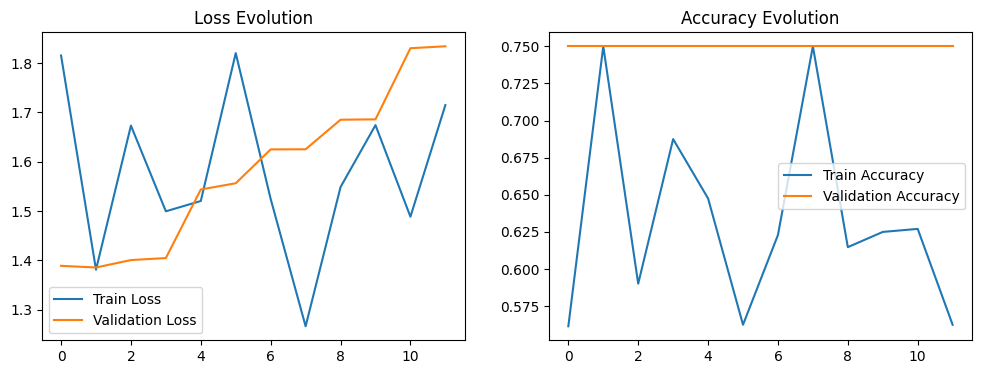

In [18]:
# Визуализация обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

## 6.	Попробуйте проделать действия с использованием AutoML и сравните ратоту.

#### TPOT

In [19]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import cv2

In [20]:
import os
list_plus = [file for file in os.listdir(FOLDER_SEIZURE) if file.endswith('.png')]
list_minus = [file for file in os.listdir(FOLDER_NON_SEIZURE) if file.endswith('.png')]

In [21]:
# Подготовка данных
image_files = glob('EEG2/data/seizure/*.png') + glob('EEG2/data/non_seizure/*.png')
labels = ['seizure'] * len(list_plus) + ['non_seizure'] * len(list_minus)

# Загрузка и преобразование изображений
X = []
for img_path in image_files:
    img = Image.open(img_path).resize((64, 64))  # Ресайз через PIL
    X.append(np.array(img).flatten())  # в numpy и затем в 1D вектор

# Преобразуем список в numpy array
X = np.array(X)

# Кодирование меток
le = LabelEncoder()
y = le.fit_transform(labels)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    random_state=42,
    n_jobs=-1,
    config_dict='TPOT light'  
)

tpot.fit(X_train, y_train)


print(f"Accuracy: {accuracy_score(y_test, tpot.predict(X_test)):.2f}")

# tpot.export('EEG2/eeg_tpot_pipeline.py')

Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7953242835595777

Generation 2 - Current best internal CV score: 0.7953242835595777


Traceback (most recent call last):
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/stopit/utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/tpot/decorators.py", line 57, in time_limited_call
    func(*args)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/sklearn/pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwar


Generation 3 - Current best internal CV score: 0.7953242835595777


Traceback (most recent call last):
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/stopit/utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/tpot/decorators.py", line 57, in time_limited_call
    func(*args)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/sklearn/pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwar


Generation 4 - Current best internal CV score: 0.8068627450980392


Traceback (most recent call last):
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/stopit/utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/tpot/decorators.py", line 57, in time_limited_call
    func(*args)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/sklearn/pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwar


Generation 5 - Current best internal CV score: 0.8068627450980392

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=1, p=2, weights=distance)
Accuracy: 0.72


In [22]:
tpot

TPOTClassifier(config_dict='TPOT light', generations=5, n_jobs=-1,
               population_size=20, random_state=42, verbosity=2)

In [24]:
# Оценка с оптимизацией порога
test_predict = tpot.predict_proba(X_test)[:, 1]
print(f"\nROC-AUC: {roc_auc_score(y_test, test_predict):.4f}")

# Поиск оптимального порога через F1-score
# thresholds = np.linspace(0, 1, 100)
# f1_scores = [f1_score(y_test, (test_predict >= t).astype(int)) for t in thresholds]
# best_threshold = thresholds[np.argmax(f1_scores)]
# print(f'Best threshold: {best_threshold:.4f}')
best_threshold = 0.5

# Метрики на валидации
y_pred_test = (test_predict >= best_threshold).astype(int)
print("\nValidation Metrics:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("F1-score:", f1_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))


ROC-AUC: 0.6190

Validation Metrics:
Confusion Matrix:
 [[40  6]
 [12  7]]
F1-score: 0.4375
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82        46
           1       0.54      0.37      0.44        19

    accuracy                           0.72        65
   macro avg       0.65      0.62      0.63        65
weighted avg       0.70      0.72      0.71        65



#### FEDOT

In [25]:
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from glob import glob


# Создание и обучение FEDOT модели
task = Task(TaskTypesEnum.classification)
fedot_model = Fedot(problem='classification', 
                    task_params=task.task_params,
                    timeout=10,
                    n_jobs=-1,
                    preset='fast_train')


pipeline = fedot_model.fit(features=X_train, target=y_train)


y_pred = fedot_model.predict(features=X_test)
print(f"FEDOT Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Сохранение пайплайна
# fedot_model.save('EEG2/eeg_fedot_pipeline')

Level 100:root:Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'


2025-04-18 21:00:11,621 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'


Level 45:root:ApiComposer - Initial pipeline was fitted in 56.4 sec.


2025-04-18 21:01:08,592 - ApiComposer - Initial pipeline was fitted in 56.4 sec.


Level 45:root:ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 282.2 sec.


2025-04-18 21:01:08,593 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 282.2 sec.


Level 45:root:ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 10 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].


2025-04-18 21:01:08,599 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 10 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].


Level 45:root:ApiComposer - Timeout is too small for composing and is skipped because fit_time is 282.17046 sec.


2025-04-18 21:01:08,629 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 282.17046 sec.


Level 45:root:ApiComposer - Hyperparameters tuning started with 9 min. timeout


2025-04-18 21:01:08,635 - ApiComposer - Hyperparameters tuning started with 9 min. timeout


Level 45:root:SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 12}
scaling - {} 
Initial metric: [0.825]


2025-04-18 21:06:01,919 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 12}
scaling - {} 
Initial metric: [0.825]
  0%|                                            | 1/100000 [05:06<8501:29:51, 306.06s/trial, best loss: -0.7865686286722725]


Level 45:root:SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 12}
scaling - {}


2025-04-18 21:16:00,299 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 12}
scaling - {}


Level 45:root:SimultaneousTuner - Final metric: 0.825


2025-04-18 21:16:00,301 - SimultaneousTuner - Final metric: 0.825


Level 45:root:ApiComposer - Hyperparameters tuning finished


2025-04-18 21:16:00,304 - ApiComposer - Hyperparameters tuning finished


Level 45:root:ApiComposer - Model generation finished


2025-04-18 21:16:00,690 - ApiComposer - Model generation finished


Level 45:root:FEDOT logger - Final pipeline was fitted


2025-04-18 21:16:39,960 - FEDOT logger - Final pipeline was fitted


Level 45:root:FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 12}
scaling - {}


2025-04-18 21:16:39,962 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 12}
scaling - {}
FEDOT Accuracy: 0.82


In [26]:
y_test.shape, y_pred.shape, X_test.shape

((65,), (65, 1), (65, 16384))

In [27]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")

# Поиск оптимального порога через F1-score
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, (y_pred >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Best threshold: {best_threshold:.4f}')

# Метрики на валидации
y_pred_test = (y_pred >= best_threshold).astype(int)
print("\nValidation Metrics:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("F1-score:", f1_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))


ROC-AUC: 0.6842
Best threshold: 0.0101

Validation Metrics:
Confusion Matrix:
 [[46  0]
 [12  7]]
F1-score: 0.5384615384615384
Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        46
           1       1.00      0.37      0.54        19

    accuracy                           0.82        65
   macro avg       0.90      0.68      0.71        65
weighted avg       0.85      0.82      0.78        65



#### lightautoml

In [28]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task


X_df = pd.DataFrame(X)
X_df.columns = [f'pixel_{i}' for i in range(X_df.shape[1])]  # имена признакам
y = LabelEncoder().fit_transform(labels)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)


task = Task('binary', metric='accuracy')

# Настройки AutoML
automl = TabularAutoML(
    task=task,
    timeout=300,  
    cpu_limit=-1, 
    general_params={'use_algos': [['lgb', 'lgb_tuned', 'linear_l2', 'cb', 'cb_tuned']]},
    reader_params={'cv': 3, 'random_state': 42}
)


oof_pred = automl.fit_predict(
    {'data': X_train, 'target': y_train},
    roles={'target': 'target'}
)

# Предсказание и оценка
y_pred = automl.predict(X_test).data[:, 0]
print(f"LightAutoML Accuracy: {accuracy_score(y_test, y_pred > 0.5):.2f}")


LightAutoML Accuracy: 0.77


In [29]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")

# Поиск оптимального порога через F1-score
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, (y_pred >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Best threshold: {best_threshold:.4f}')

# Метрики на валидации
y_pred_test = (y_pred >= best_threshold).astype(int)
print("\nValidation Metrics:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("F1-score:", f1_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))


ROC-AUC: 0.9119
Best threshold: 0.2727

Validation Metrics:
Confusion Matrix:
 [[37  9]
 [ 2 17]]
F1-score: 0.7555555555555555
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87        46
           1       0.65      0.89      0.76        19

    accuracy                           0.83        65
   macro avg       0.80      0.85      0.81        65
weighted avg       0.86      0.83      0.84        65



#### MLFlow

In [30]:
import mlflow
from mlflow.pyfunc import PythonModel

class LightAutoMLWrapper(PythonModel):
    def __init__(self, automl):
        self.automl = automl
        
    def predict(self, context, model_input):
        predictions = self.automl.predict(model_input)
        # Convert NumpyDataset to JSON-serializable format
        return predictions.data[:, 0]

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("ppa_lab")

/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


<Experiment: artifact_location='/Users/vladimir/Desktop/University/ppa/labs/artifacts/3', creation_time=1744904699558, experiment_id='3', last_update_time=1744904699558, lifecycle_stage='active', name='ppa_lab', tags={}>

In [40]:
lab = 'lr5'
# Save to MLflow
with mlflow.start_run(run_name=lab):
    wrapped_model = LightAutoMLWrapper(automl)

    mlflow.pyfunc.log_model(
        artifact_path=lab,
        python_model=wrapped_model,
    )

2025/04/19 00:15:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run lr5 at: http://localhost:5000/#/experiments/3/runs/9591d0890edf4785b14b0b30b3843c81
🧪 View experiment at: http://localhost:5000/#/experiments/3


In [41]:
# проверка корректности выгрузки модели из mlflow
run_id = '9591d0890edf4785b14b0b30b3843c81'
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/{lab}")
predictions_mlflow = loaded_model.predict(X_test)

In [42]:
# сохранение артефактов локально
mlflow.artifacts.download_artifacts(
    run_id=run_id,
    artifact_path=lab, 
    dst_path="./downloaded_model"
)

'/Users/vladimir/Desktop/University/ppa/labs/downloaded_model/lr5'

In [44]:
# !mlflow models serve -m "./downloaded_model/lr5" --port 1234 --no-conda
# проверка сервиса
!curl http://localhost:1234/ping

In [45]:

import requests

# отправка post запроса к развернутому сервису
response = requests.post(
    "http://localhost:1234/invocations",
    json={"dataframe_records": X_test.to_dict(orient="records")}
)


In [46]:
predictions_mlflow_server = response.json()['predictions']

In [47]:
test_predict = automl.predict(X_test).data.flatten()

In [48]:
np.allclose(predictions_mlflow, test_predict)

True

In [49]:
np.allclose(predictions_mlflow_server, test_predict)

True

Сохранение модели в mlflow и ее развертывание с помощью mlflow server прошло корректно, резульаты работы модели совпадают с исходными